## Example 4 - Blocking the right paths in the network 

Here we investigate the the hypothesised pathway from Barents and Kara sea ice (BK) in autumn to the Stratospheric polar vortex (SPV) in winter via affecting sea level pressure over the Ural Mountains region (URAL). The latter is also assumed to affect BK. Moreover, the El Niño Southern Oscillation (ENSO) and the Madden Julien Oscillation (MJO) influence North Pacific sea level pressure (NP), and thereby both the SPV and BK.


<img src="../images/ex4.png" width="500" height="600">

# Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import iris
import iris.quickplot as qplt
import iris.coord_categorisation as coord_cat
import statsmodels.api as sm
from scipy import signal
from scipy import stats

## Step 1) Load the data + Extract regions of interest


In [2]:
bk_sic = iris.load_cube('../sample_data/bk_sic.nc', "sic")
nh_spv = iris.load_cube('../sample_data/nh_spv_uwnd.nc', "uwnd")
np_slp = iris.load_cube('../sample_data/np_slp.nc', "slp")
ural_slp = iris.load_cube('../sample_data/ural_slp.nc', "slp")

In [3]:
# make seasonal means

def do_mean_over_months(data_cube, list_months):

    # extract months of interest
    ond_constraint = iris.Constraint(month=lambda v: v in list_months) # ['Oct','Nov', 'Dec'])
    precip_ond = data_cube.extract(ond_constraint)

    # create the mean
    precip_ond_mean = precip_ond.aggregated_by(['year'],iris.analysis.MEAN)
    
    return precip_ond_mean

In [4]:
bk = do_mean_over_months(bk_sic, ['Oct','Nov', 'Dec']) 
spv = do_mean_over_months(nh_spv, ['Jan','Feb', 'Mar'])
ural = do_mean_over_months(ural_slp, ['Oct','Nov', 'Dec'])
pac = do_mean_over_months(np_slp, ['Oct','Nov', 'Dec'])

### plot the time-series

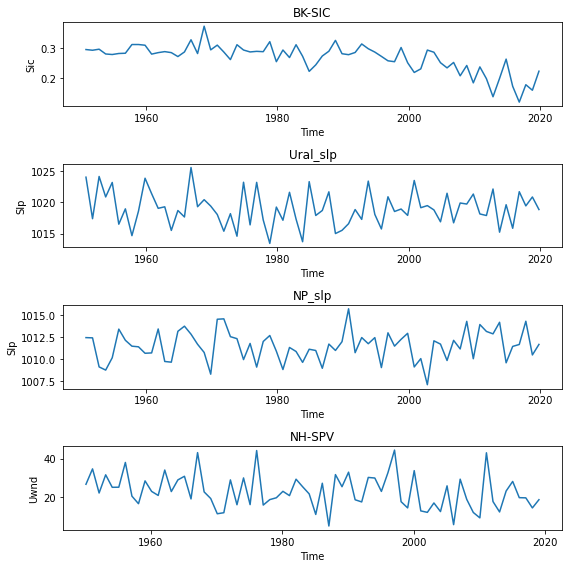

In [5]:
fig = plt.figure(figsize=(8, 8))

plt.subplot(411)
qplt.plot(bk)
plt.title('BK-SIC')

plt.subplot(412)
qplt.plot(ural)
plt.title('Ural_slp')

plt.subplot(413)
qplt.plot(pac)
plt.title('NP_slp')

plt.subplot(414)
qplt.plot(spv)
plt.title('NH-SPV')
plt.tight_layout()


## Step 2) Data processing


#### standardize

In [6]:
BK = (bk - np.mean(bk.data))/np.std(bk.data)
SPV = (spv - np.mean(spv.data))/np.std(spv.data)
URAL = (ural - np.mean(ural.data))/np.std(ural.data)
NP = (pac - np.mean(pac.data))/np.std(pac.data)


#### detrend

In [7]:
y0 = 0
BK = signal.detrend(BK[y0:].data)
SPV = signal.detrend(SPV[y0:].data)
URAL = signal.detrend(URAL[y0:].data)
NP = signal.detrend(NP[y0:].data)


## Step 3) Data analysis

In [8]:
#================================================================
# Determine the effect of ENSO on CA conditioned on Jet
#================================================================

# note the one-calendar year lag between the autumn drivers BK, URAL, NO and the reponse variable of winter SPV

X = np.stack([BK[:-1], URAL[:-1], NP[:-1]]).T
Y = SPV[1: ]

model = sm.OLS(Y,X)
results = model.fit()

ce_x1 = results.params[0]
ce_x2 = results.params[1]
ce_x3 = results.params[2]

print("The causal effect of BK-SIC on SPV is (cond on URAL , NP)", round(ce_x1,3))
print('\n')
print("The regression coeff. of URAL on SPV is ", round(ce_x2,3))
print("The regression coeff. of NP on SPV is ", round(ce_x3,3))


The causal effect of BK-SIC on SPV is (cond on URAL , NP) 0.213


The regression coeff. of URAL on SPV is  -0.0
The regression coeff. of NP on SPV is  0.268
